In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk as nlp
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_true["text"] = df_true["text"].replace("(Reuters)","",regex=True)
df_fake["target"] = 0
df_true["target"] = 1
df_fake = df_fake.drop(["title","subject","date"],axis = 1)
df_true = df_true.drop(["title","subject","date"],axis = 1)
df = pd.concat([df_fake,df_true],axis = 0)
df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop(["index"], axis = 1, inplace = True)

In [3]:
import re
import string
def wordopt(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text


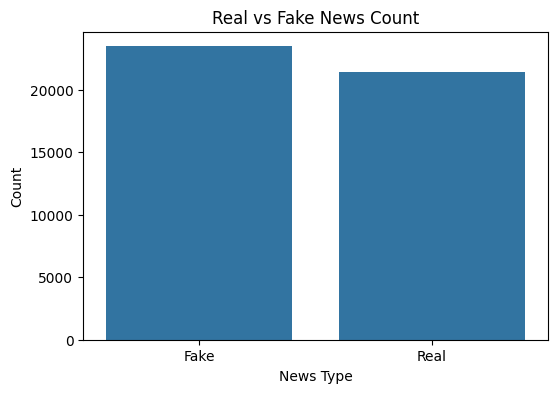

In [4]:
df["text"] = df["text"].apply(wordopt)
#class distribution of fake vs real news
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Real vs Fake News Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

In [5]:
#Analysis of news type csv files: There is a much larger amount of fake news headlines to real news headlines. This could create conflicts with our model as it is being trained on datasets with many more fake news headlines to real news headlines.

In [ ]:
X = df["text"]
Y = df["target"]
X_train,x_test,Y_train,y_test = train_test_split(X,Y,test_size=0.75)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
analyze = vectorization.build_analyzer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(x_test)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(xv_train,Y_train)
print("The Accuracy of the Logistic Regression Model is {}".format(lr.score(xv_test,y_test)))
print(classification_report(y_test,lr.predict(xv_test)))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(xv_train,Y_train)
print("The Accuracy of the Decision Tree Classifier Model is {}".format(dtc.score(xv_test,y_test)))
print(classification_report(y_test,dtc.predict(xv_test)))

#The logistic regression model has a much better accuracy rate than the Decision tree model. We will use the logistic regression model over the decision tree classifier model.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gclf = GradientBoostingClassifier()
gclf.fit(xv_train,Y_train)
print("The Accuracy of the Gradient Boosting Classifier Model is {}".format(gclf.score(xv_test,y_test)))
print(classification_report(y_test,gclf.predict(xv_test)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rclf = RandomForestClassifier()
rclf.fit(xv_train,Y_train)
print("The Accuracy of the Random Forest Classifier Model is {}".format(rclf.score(xv_test,y_test)))
print(classification_report(y_test,rclf.predict(xv_test)))

In [ ]:
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = lr.predict(new_xv_test)
    pred_DT = dtc.predict(new_xv_test)
    pred_GBC = gclf.predict(new_xv_test)
    pred_RFC = rclf.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \nDT Prediction: {} \nGBC Prediction: {} \nRFC Prediction: {}".format(output_lable(pred_LR[0]),                                                                                                       output_lable(pred_DT[0]), 
                                                                                                              output_lable(pred_GBC[0]), 
                                                                                                              output_lable(pred_RFC[0])))

In [ ]:
test_cases = [
    "Government launches new healthcare initiative.",
    "Scientists claim to have found life on Mars!",
    "This article is a hoax to trick you."
]

for article in test_cases:
    manual_testing(article)


In [ ]:
#Web Scraping From Articles Online
import requests
from bs4 import BeautifulSoup

def scrape_reuters():
    url = "https://www.reuters.com"
    headlines = []
    try:
        res = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        soup = BeautifulSoup(res.content, 'html.parser')
        for tag in soup.find_all(['h1', 'h2', 'h3']):
            text = tag.get_text(strip=True)
            if len(text) > 40 and len(text.split()) > 5:
                headlines.append(text)
    except Exception as e:
        print(f"[Reuters] Error: {e}")
    return headlines[:5]

def scrape_cnn():
    url = "https://www.cnn.com"
    headlines = []
    try:
        res = requests.get(url)
        soup = BeautifulSoup(res.content, "html.parser")
        for tag in soup.find_all(['h2', 'span']):
            text = tag.get_text(strip=True)
            if len(text) > 40 and len(text.split()) > 5:
                headlines.append(text)
    except Exception as e:
        print(f"[CNN] Error: {e}")
    return headlines[:5]

def scrape_bbc():
    url = "https://www.bbc.com"
    headlines = []
    try:
        res = requests.get(url)
        soup = BeautifulSoup(res.content, "html.parser")
        for tag in soup.find_all(['h3', 'h2']):
            text = tag.get_text(strip=True)
            if len(text) > 40 and len(text.split()) > 5:
                headlines.append(text)
    except Exception as e:
        print(f"[BBC] Error: {e}")
    return headlines[:5]
def test_scraped_headlines():
    sources = {
        "Reuters": scrape_reuters(),
        "CNN": scrape_cnn(),
        "BBC": scrape_bbc()
    }

    for source, headlines in sources.items():
        print(f"\n==== {source} Headlines ====")
        for idx, headline in enumerate(headlines, 1):
            print(f"\n{idx}. {headline}")
            manual_testing(headline)
test_scraped_headlines()


In [ ]:
#distribution of text lengths by class (real vs fake)
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='text_length', hue='target', bins=50, kde=True)
plt.title('Distribution of Text Lengths by Class')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.legend(['Fake', 'Real'])
plt.show()

from wordcloud import WordCloud

# Combine all words by class
real_words = ' '.join(df[df['target'] == 1]['text'])
fake_words = ' '.join(df[df['target'] == 0]['text'])

# WordClouds
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_words)
wordcloud_fake = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(fake_words)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Real News WordCloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Fake News WordCloud')
plt.axis('off')

plt.tight_layout()
plt.show()

#Top N words by frequency
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

top_words = get_top_n_words(df['text'], 15)
top_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=top_df)
plt.title('Top 15 Most Frequent Words')
plt.show()

In [ ]:
# Diagnostic script for Fake News Detection

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. CONFIDENCE SCORES
def show_prediction_confidence(news):
    processed_text = wordopt(news)
    transformed_text = vectorization.transform([processed_text])
    probs = lr.predict_proba(transformed_text)
    print(f"\nPrediction: {output_lable(lr.predict(transformed_text)[0])}")
    print(f"Probability it's real: {probs[0][1]:.4f}")
    print(f"Probability it's fake: {probs[0][0]:.4f}")

# 2. FEATURE IMPORTANCE
def print_top_features():
    feature_names = vectorization.get_feature_names_out()
    coefficients = lr.coef_[0]
    top_fake_idx = np.argsort(coefficients)[-10:]
    top_real_idx = np.argsort(coefficients)[:10]

    print("\nTop words indicating REAL news:")
    for i in top_real_idx:
        print(f"{feature_names[i]}: {coefficients[i]:.4f}")

    print("\nTop words indicating FAKE news:")
    for i in reversed(top_fake_idx):
        print(f"{feature_names[i]}: {coefficients[i]:.4f}")

# 3. CONFUSION MATRIX
def plot_confusion_matrix():
    y_pred = lr.predict(xv_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix - Logistic Regression")
    plt.show()

# 4. MISCLASSIFIED EXAMPLES
def show_misclassified_examples():
    y_pred = lr.predict(xv_test)
    false_negatives = x_test[(y_test == 1) & (y_pred == 0)]  # Real predicted as Fake
    false_positives = x_test[(y_test == 0) & (y_pred == 1)]  # Fake predicted as Real

    print("\n--- False Negatives (Real predicted as Fake) ---")
    for article in false_negatives.sample(3, random_state=1):
        print(f"\n{article[:500]}\n{'-'*60}")

    print("\n--- False Positives (Fake predicted as Real) ---")
    for article in false_positives.sample(3, random_state=1):
        print(f"\n{article[:500]}\n{'-'*60}")

# 5. FULL DIAGNOSTIC FUNCTION
def run_full_diagnostics(news_input):
    show_prediction_confidence(news_input)
    print_top_features()
    plot_confusion_matrix()
    show_misclassified_examples()

# Example usage:
run_full_diagnostics("NASA confirms discovery of water on the sunlit surface of the Moon")
